In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [2]:
import seaborn as sns

In [3]:
X_test = pd.read_csv('Data/X_test.csv')
X_train = pd.read_csv('Data/X_train.csv')
y_train = pd.read_csv('Data/y_train.csv')

In [4]:
def get_values_X_2D(X):
    n_timestep, n_feature = 128, 10
    X_data_ori = X.iloc[:,3:].values # original values
    #X_data = StandardScaler().fit_transform(X_data_ori)# standarlize the data
    #X_data = MinMaxScaler().fit_transform(X_data)# standarlize the data

    X_data_2D = np.reshape(X_data_ori, (int(len(X_data_ori)/n_timestep),n_timestep,n_feature)) # convert to 2D images
    return (X_data_2D)

In [5]:
X_data_2D = get_values_X_2D(X_train)
all_group = y_train.surface.unique()

In [6]:
all_group

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

## LSTM models

In [7]:
# cnn model
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
import numpy as np
from keras import backend as K
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM, Input
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.optimizers import Adam

Using TensorFlow backend.


In [8]:
def prepare_dataset(X, y_data):
    n_timestep, n_feature = 128, 10
    
    X_data = X.iloc[:,3:].values # original values
    #X_data = StandardScaler().fit_transform(X_data)# standarlize the data
    #X_data = MinMaxScaler().fit_transform(X_data)# standarlize the data

    X_data_2D = np.reshape(X_data, (int(len(X_data)/n_timestep),n_timestep,n_feature)) # convert to 2D images
    
    # integer encode
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(y_data)
    # binary encode
    onehot_encoder = OneHotEncoder(sparse=False, categories='auto')
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    y_onehot_encoded = onehot_encoder.fit_transform(integer_encoded)

    X_train, X_test, y_train, y_test = train_test_split(X_data_2D, y_onehot_encoded, test_size=0.4, random_state=42)
    print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
    return(label_encoder, X_train, y_train, X_test, y_test)


In [9]:
def focal_loss(gamma=2, alpha=0.75):
    def focal_loss_fixed(y_true, y_pred):#with tensorflow
        eps = 1e-12
        y_pred=K.clip(y_pred,eps,1.-eps)#improve the stability of the focal loss and see issues 1 for more information
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.sum(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1))-K.sum((1-alpha) * K.pow( pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [10]:
def create_model(n_timesteps,n_features,n_outputs):
    model = Sequential()
    #model.add(Input(shape = (n_timesteps,n_features)))
    model.add(BatchNormalization(input_shape = (n_timesteps,n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(LSTM(100, return_sequences=True))

    model.add(LSTM(100, return_sequences=False))

    #model.add(Flatten())
    model.add(Dense(n_outputs, activation='softmax'))
    model.summary()
    return (model)
    

In [17]:
#fit and evaluate a model
def evaluate_model(trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 1, 1000, 500
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    
    class_weight = {0: 2.,
                1: 1.,
                2: 3.,
                3: 1.,
                4: 1.,
                5: 3.,
                6: 4.,
                7: 20.,
                8: 1}
    
    model = create_model(n_timesteps,n_features,n_outputs)
    opt = Adam(lr = 0.0005)
    focal_loss_fixed = focal_loss()
    model.compile(loss=focal_loss_fixed, optimizer=opt, metrics=['accuracy'])
    # fit network
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30)
    mc = ModelCheckpoint('best_model_lstm_only.hdf5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)
    # fit model
    history = model.fit(trainX, trainy, validation_data=(testX, testy), epochs=epochs, \
                        batch_size=batch_size, verbose=verbose,  callbacks=[es, mc])

    pyplot.plot(history.history['loss'], label='train')
    pyplot.plot(history.history['val_loss'], label='test')
    pyplot.legend()
    pyplot.show()
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))

# run an experiment
def run_experiment(repeats=10):
    # load data
    label_encoder, trainX, trainy, testX, testy = prepare_dataset(X_train, y_train.surface)
    # repeat experiment
    scores = list()
    for r in range(repeats):
        score = evaluate_model(trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r+1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)
    
    return (label_encoder)

(2286, 128, 10) (1524, 128, 10) (2286, 9) (1524, 9)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_3 (Batch (None, 128, 10)           40        
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 126, 64)           1984      
_________________________________________________________________
lstm_5 (LSTM)                (None, 126, 100)          66000     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_3 (Dense)              (None, 9)                 909       
Total params: 149,333
Trainable params: 149,313
Non-trainable params: 20
_________________________________________________________________
Train on 2286 samples, validate on 1524 samples
Epoch 1/1000
2286/2286 [===========

2286/2286 [==============================] - 3s 1ms/step - loss: 174.5790 - acc: 0.7030 - val_loss: 218.7564 - val_acc: 0.6640

Epoch 00033: val_acc improved from 0.65092 to 0.66404, saving model to best_model_lstm_only.hdf5
Epoch 34/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 184.4080 - acc: 0.6745 - val_loss: 234.3024 - val_acc: 0.6286

Epoch 00034: val_acc did not improve from 0.66404
Epoch 35/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 187.3512 - acc: 0.6798 - val_loss: 227.9433 - val_acc: 0.6660

Epoch 00035: val_acc improved from 0.66404 to 0.66601, saving model to best_model_lstm_only.hdf5
Epoch 36/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 181.6259 - acc: 0.6938 - val_loss: 216.7114 - val_acc: 0.6654

Epoch 00036: val_acc did not improve from 0.66601
Epoch 37/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 174.0459 - acc: 0.6977 - val_loss: 202.1935 - val_acc: 0.6864

Epoch 0003

2286/2286 [==============================] - 3s 1ms/step - loss: 107.9890 - acc: 0.7927 - val_loss: 178.7486 - val_acc: 0.6969

Epoch 00073: val_acc did not improve from 0.72769
Epoch 74/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 123.4698 - acc: 0.7568 - val_loss: 191.8440 - val_acc: 0.7192

Epoch 00074: val_acc did not improve from 0.72769
Epoch 75/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 136.4225 - acc: 0.7511 - val_loss: 181.2692 - val_acc: 0.7113

Epoch 00075: val_acc did not improve from 0.72769
Epoch 76/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 135.6645 - acc: 0.7441 - val_loss: 195.0299 - val_acc: 0.6811

Epoch 00076: val_acc did not improve from 0.72769
Epoch 77/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 118.5992 - acc: 0.7782 - val_loss: 168.8318 - val_acc: 0.7244

Epoch 00077: val_acc did not improve from 0.72769
Epoch 78/1000
2286/2286 [=============================

2286/2286 [==============================] - 3s 1ms/step - loss: 68.1383 - acc: 0.8460 - val_loss: 153.8987 - val_acc: 0.7474

Epoch 00114: val_acc did not improve from 0.76247
Epoch 115/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 66.3067 - acc: 0.8657 - val_loss: 153.3622 - val_acc: 0.7526

Epoch 00115: val_acc did not improve from 0.76247
Epoch 116/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 64.2197 - acc: 0.8605 - val_loss: 152.5127 - val_acc: 0.7605

Epoch 00116: val_acc did not improve from 0.76247
Epoch 117/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 69.6262 - acc: 0.8508 - val_loss: 195.2142 - val_acc: 0.7231

Epoch 00117: val_acc did not improve from 0.76247
Epoch 118/1000
2286/2286 [==============================] - 3s 1ms/step - loss: 89.6201 - acc: 0.8325 - val_loss: 171.5738 - val_acc: 0.7290

Epoch 00118: val_acc did not improve from 0.76247
Epoch 119/1000
2286/2286 [=============================

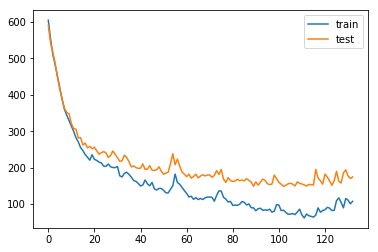

>#1: 72.047
[72.04724329663074]
Accuracy: 72.047% (+/-0.000)


In [18]:
# run the experiment
label_encoder = run_experiment(1)

In [13]:
def model_prediction(label_encoder):
    # prediction of the test set
    model = create_model(128,10,9)
    model.load_weights('best_model_lstm_only.hdf5')
    
    test = pd.read_csv('Data/X_test.csv')
    data_test = get_values_X_2D(test)

    predicted = model.predict(data_test)
    result=label_encoder.inverse_transform(predicted.argmax(axis=1))
    result_pd = pd.DataFrame({'series_id': list(range(len(result))), 'surface':result})
    return (result_pd)

In [14]:
result_pd = model_prediction(label_encoder)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_2 (Batch (None, 128, 10)           40        
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 126, 64)           1984      
_________________________________________________________________
lstm_3 (LSTM)                (None, 126, 100)          66000     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_2 (Dense)              (None, 9)                 909       
Total params: 149,333
Trainable params: 149,313
Non-trainable params: 20
_________________________________________________________________


In [15]:
result_pd.groupby('surface').count()

,series_id
surface,
carpet,151
concrete,878
fine_concrete,310
hard_tiles,15
hard_tiles_large_space,297
soft_pvc,602
soft_tiles,404
tiled,479
wood,680


In [16]:
result_pd.to_csv('focaloss.csv', index= False)